In [420]:
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [421]:
data = pd.read_csv('../data/provData/x_train.csv').set_index('Provider')

data.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace=True)

data.fillna(0, inplace=True)
data['LargeClaims'] = data['ClaimID'] > 1300

In [422]:
data_test = pd.read_csv('../data/provData/x_test.csv').set_index('Provider')
data_test.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace=True)
data_test.fillna(0, inplace=True)
data_test.head()

,Age,Gender,BeneID,ClaimID,NumDiag,InscClaimAmtReimbursed,OPAnnualReimbursementAmt,IPAnnualReimbursementAmt,TotalClaim,InscCovPercent,...,InscCovPercent_Range,DailyCharge_Range,docDegMax,docBtwnMean,docEignMean,docMANN,patDegMax,patBtwnMean,patEignMean,patMANN
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51002,71.926829,71,169,205,2.878049,53790,2345.073171,5180.926829,264.243902,0.989728,...,0.777778,6010.0,9,105.477418,0.144884,2.466667,127,855.435281,0.149826,261.043080
PRV51006,74.343137,43,81,102,3.019608,30720,2401.666667,3767.549020,301.176471,1.000000,...,0.000000,2100.0,7,381.813986,0.002511,7.000000,92,196.902090,0.143410,76.771978
PRV51009,69.102564,16,30,39,3.256410,27230,2441.025641,3004.102564,729.948718,0.968461,...,0.666667,3300.0,2,98.000000,0.000856,14.500000,47,27.375165,0.089613,119.037313
PRV51010,74.815789,23,25,38,3.447368,64580,1775.789474,5268.421053,1840.000000,0.975097,...,0.262537,5068.0,5,1012.666667,0.000177,4.285714,39,76.288550,0.041593,109.133333
PRV51018,72.915789,66,146,190,2.868421,61620,2812.947368,4738.947368,327.842105,0.969389,...,1.000000,3300.0,5,56.532737,0.089660,11.000000,116,290.838499,0.203971,102.975788


In [423]:
data.Status

AttributeError: 'DataFrame' object has no attribute 'Status'

In [4]:
data.groupby('PotentialFraud')['fraudulence'].sum()

PotentialFraud
0    4097
1     464
Name: fraudulence, dtype: int64

In [5]:
print(data.query('PotentialFraud==1 & fraudulence==1').shape)
print(data.query('PotentialFraud==1 & fraudulence==0').shape)
print(data.query('PotentialFraud==0 & fraudulence==0').shape)
print(data.query('PotentialFraud==0 & fraudulence==1').shape)

(464, 49)
(42, 49)
(807, 49)
(4097, 49)


In [6]:
data.shape

(5410, 49)

In [7]:
464/5410

0.08576709796672828

## Metrics

### Recall
Recall (or sensitivity or true positive rate) is the fraction of observations having a true class of 1 (potentially fraudulent) that are being correctly classified as such. Recall is exactly how many of the fradulent providers we are actually classifying as fraudulent.

If we have a problem like cancer detection, we would ideally want our system to have very high recall, potentially at the expense of false postives or accuracy in general.

### F1 Score
F1 score is the harmonic mean of recall and precision, and it can be thought of as a balance of the two. While accuracy also serves this purpose, it can be quite misleading if classes are heavily imbalanced. In our case, only 9% of providers have been labeled as fraudulent and we assume the test set follows the same distribution. 

For instance, suppose we have a population of 1000 providers and 100 of them are fraudulent. We have a classfication system that produces the following results:

- 40 True Positive (correctly identified fraud)
- 10 False Positives (incorrectly mistook non-fraud for fraud)
- 20 False Negative (failed to identify fraud)
- 930 True Negatives (correctly identified non-fraud)

In this example, we have 93.0% accuracy while the F1 score is 72.7% (and 80% precision, 67% recall), which seems to be a more useful overall indicator of performance in this case.

### ROC Curve and AUC
The receiver operating characteristic curve (or ROC curve) is another tool for evaluating the classfication performance of different models. For any given model, the ROC curve plots the tradoff between the false positive rate on the x-axis against the true positive rate (aka Precision) for different choices of thresholds for a binary classifier. In one extreme case, if the classification threshold is 0, then all instances (for non-perfect models) will be classified as 0, leading to a false positive rate of 0, but also a true postive rate of 0. In the other extreme case, a threshold of 1 leads to a true positive rate/recall of 1 but also a false postive rate of 1. 

In terms of evaluating classification performance, an ROC curve which is closer to the (FPR = 0, TPR = 1) point compared to another indicates that the former model strictly dominates the latter. Beyond just the curve, one summary measure is simply the AUC or (A)rea (U)nder the ROC (C)urve. A completely random model will produce an AUC of 0.5 while a perfect model will have an AUC of 1.

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
from scipy import stats


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def confusion(x,y,model):
    confusion_matrix(y,model.predict(x))
    print_cm(confusion_matrix, labels = ['NoFraud','Fraud'])
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


def feature_importance(model, columns, name, note):
    coefs = pd.DataFrame(np.dstack((
        columns,model.named_steps[name].coef_.round(4)))[0], 
                         columns = ['Features','Coefficients']).\
    sort_values('Coefficients',ascending=True).set_index('Features')
    
    coefs.plot(kind='barh', figsize=(9,7))
    plt.title(name + ' ' + note)
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    #print(coefs)


def logitMetrics(x,y, model):
    logit_tr_acc = model.score(x, y)
    logit_tr_pr, logit_tr_re, logit_tr_f1, _ = precision_recall_fscore_support(y, model.predict(x))

    print(" Logit Train Accuracy : %1.3f" % (logit_tr_acc))
    print(" Logit Train Precision: %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_pr[0], logit_tr_pr[1]))
    print(" Logit Train Recall   : %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_re[0], logit_tr_re[1]))
    print(" Logit Train F1 Score : %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_f1[0], logit_tr_f1[1]))
    
def ROC(x,y, model):
    y_probs_logit = pd.DataFrame(model.predict_proba(x))[1]
    fpr, tpr, thresholds = roc_curve(y, y_probs_logit)
    auc = roc_auc_score(y, y_probs_logit)  # Computes auc
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
            label='ROC logit (area = %0.2f)' % auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0, 1.02])
    plt.ylim([0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Curve')
    plt.legend(loc="lower right")
    plt.show()

## Ridge Pipeline

## Check Performance

In [10]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts

def two_stage_model_predict(X,y):
    
    ## Stage 1 Classifier
    name = 'LogReg'

    X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size = 1.0/3)

    steps = [('scaler', StandardScaler()),
             (name, LogisticRegression())]

    model_stage1 = Pipeline(steps = steps)
    _ = model_stage1.fit(X_train,y_train)
    
    coefs_1 = pd.DataFrame(np.dstack((
        X.columns,model_stage1.named_steps[name].coef_.round(4),model_stage1['scaler'].scale_))[0], 
                         columns = ['Features','Coefficients_1','Scale_1']).\
    sort_values('Coefficients_1',ascending=True).set_index('Features')

    ## Stage 2 Classifier
    y_pred1 = model_stage1.predict(X)

    stage1 = pd.DataFrame({'Target' : y, 'Prediction' : y_pred1})

    y_correct1 = stage1.query('Target == Prediction')[['Prediction']]

    y_2 = stage1.query('Target != Prediction')['Target']
    
    idx1 = y_1.index
    idx2 = y_2.index
    X_1 = data.loc[idx1,:]
    X_2 = data.loc[idx2,:]

    X_train2, X_test2, y_train2, y_test2 = tts(X_2, y_2,random_state=0, test_size = 1.0/3)

    steps = [('scaler', StandardScaler()),
             (name, LogisticRegression())]

    model_stage2 = Pipeline(steps = steps)
    _ = model_stage2.fit(X_train2,y_train2)
    
    coefs_2 = pd.DataFrame(np.dstack((
        X_2.columns,model_stage2[name].coef_.round(4),model_stage2['scaler'].scale_))[0], 
                         columns = ['Features','Coefficients_2','Scale_2']).\
    sort_values('Coefficients_2',ascending=True).set_index('Features')

    y_pred2 = model_stage2.predict(X_2)

    stage2 = pd.DataFrame({'Target' : y_2, 'Prediction' : y_pred2})

    y_correct2 = stage2.query('Target == Prediction')[['Prediction']]

    y_pred = y_correct1.append(y_correct2)
    
    coefs = pd.merge(coefs_1,coefs_2, on='Features').reset_index()
    # Sort the index after the append to get all the ducks in a row
    return y_pred.sort_index(), coefs

In [ ]:
coefs['Rescaled_Coef_1'] = coefs['Coefficients_1']/coefs['Scale_1']
coefs['Rescaled_Coef_2'] = coefs['Coefficients_2']/coefs['Scale_2']
coefs['First'] = coefs['Rescaled_Coef_1'].apply(lambda x: np.exp(x)-1)
coefs['Second'] = coefs['Rescaled_Coef_2'].apply(lambda x: np.exp(x)-1)

coefs

In [ ]:
df = coefs.melt(value_vars = ['First','Second'], 
           id_vars = 'Features', 
           value_name = 'IncreaseInOdds', 
           var_name = 'Stage').sort_values('IncreaseInOdds',ascending=False)

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.barplot(y = 'Features',x = 'IncreaseInOdds', hue = 'Stage', data=df)
plt.xscale('log')
plt.tight_layout()
ax.set_ylabel('')
ax.set_xlabel('Increase in Odds (%)')

In [ ]:
confusion_matrix(y,y_pred)


In [ ]:
model_stage1[name].coef_

In [ ]:
y = data['PotentialFraud']
X = data[['fraudulence','ClaimID','LargeClaims','DailyCharge_Range','NumProc_in','docMANN',]]

X_train, X_test, y_train, y_test = tts(X, y,random_state=2, test_size = 1.0/5)
logit = LogisticRegression().fit(X_train,y_train)


logitMetrics(X_test,y_test,logit)
print(confusion_matrix(y_test, logit.predict(X_test)))
ROC(X_test,y_test,logit)


#feature_importance(logit, X.columns, name, 'Recall')


## Stage 1 Model Build

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split as tts

name = 'LogReg_Stage1'
over = BorderlineSMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

X_train, X_test, y_train, y_test = tts(X, y,random_state=2, test_size = 1.0/5)
X_train1, X_test1, y_train1, y_test1 = tts(X_train, y_train,random_state=6, test_size = 1.0/3)

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         (name, LogisticRegressionCV(
             Cs = np.logspace(-6,1,20),penalty='l1',
             scoring = 'recall',
             class_weight = 'balanced',
             solver='liblinear',
             max_iter=1000))]

model_stage1 = Pipeline(steps = steps)
_ = model_stage1.fit(X_train1,y_train1)

logitMetrics(X_test1,y_test1,model_stage1)
print(confusion_matrix(y_test1,model_stage1.predict(X_test1)))
ROC(X_test1,y_test1,model_stage1)


feature_importance(model_stage1, X.columns, name, 'Recall')

## Stage 1 Model Evaluation

In [ ]:
logitMetrics(X_train,y_train,model_stage1)
cm = confusion_matrix(y_train,model_stage1.predict(X_train))
tn1,fp1,fn1,tp1 = cm.ravel()
print(cm)
ROC(X_train,y_train,model_stage1)

## Subset Data for Stage 2

In [ ]:
y_pred1 = pd.DataFrame({'Prediction' : model_stage1.predict(X_train)}, index = y_train.index)
idx1 = y_pred1.query('Prediction==0')["Prediction"].index
y_1noFN = y.loc[idx1]
idx2 = y_pred1.query('Prediction==1')["Prediction"].index
#idx2 = y.index
X_2 = X.loc[idx2,:]
#X_2['LargeClaims'].value_counts()
y_2 = y.loc[idx2]

In [ ]:
X_2.columns

In [ ]:
X_2.drop(columns = [
#     'ClaimID', 
#     'NumDiag', 
    'TotalClaim', 
#     'DailyCharge',
    'DupRecord', 
    'fraudulence', 
#     'ClaimDays_in',
    'NumChronics_in',
    'NumChronics_out', 
    'fraudulence',
#     'NumProc_Range', 
#     'ClaimDays_Range',
#     'TotalClaim_Range', 
#     'InscCovPercent_Range', 
#     'DailyCharge_Range'
],inplace=True)

## Stage 2 Model Building

In [ ]:
name = 'LogReg_Stage2'
X_train2, X_test2, y_train2, y_test2 = tts(X_2, y_2,random_state=7, test_size = 1.0/3)

over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.7)


steps = [('scaler', StandardScaler()),
         ('o', over),
         ('u', under),
         (name, LogisticRegressionCV(
             Cs = np.logspace(-3,2,20),penalty='l2',
             scoring = 'recall_weighted',
             class_weight = 'balanced',
             solver='liblinear',
             max_iter=1000))]

model_stage2 = Pipeline(steps = steps)
_ = model_stage2.fit(X_train2,y_train2)

logitMetrics(X_test2,y_test2,model_stage2)
print(confusion_matrix(y_test2,model_stage2.predict(X_test2)))
ROC(X_test2,y_test2,model_stage2)

feature_importance(model_stage2, X_2.columns, name, 'Recall')

## Stage 2 Model Evaluation

In [ ]:
logitMetrics(X_2,y_2,model_stage2)
cm2 = confusion_matrix(y_2,model_stage2.predict(X_2))
tn2,fp2,fn2,tp2 = cm2.ravel()
print(cm2)
ROC(X_2,y_2,model_stage2)

y_pred2 = pd.DataFrame({'Prediction' : model_stage2.predict(X_2)}, index = y_2.index)


In [ ]:
y_pred2

In [ ]:

y_pred2 = pd.DataFrame({'Prediction' : model_stage2.predict(X_2)}, 
                       index = y_2.index)

# cm2 = confusion_matrix(y_2, y_pred2['Prediction'])
# tn2,fp2,fn2,tp2 = cm2.ravel()

final_prediction = y_1noFP.append(y_pred2['Prediction']).sort_index()

In [ ]:
final_prediction

In [ ]:
df_ = pd.DataFrame({'Prediction1' : model_stage1.predict(X_train),
              'Prediction2' : final_prediction}, 
                           index = y_train.index)
df_['and'] = df_['Prediction1'] & df_['Prediction2']
df_

In [ ]:
df = pd.DataFrame({'Prediction1' : model_stage1.predict(X_train),
              'Prediction2' : model_stage2.predict(X_train)}, 
                           index = y_train.index)
df['and'] = df['Prediction1'] & df['Prediction2']
df

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

name = 'Ridge_Classifier_Recall'
over = BorderlineSMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.8)

steps = [#('o', over),
         #('u', under),
         (name, RidgeClassifierCV(alphas = np.logspace(-2,2,10),
                                class_weight='balanced',
                                scoring = 'f1_weighted',
                                store_cv_values = True))]


model = Pipeline(steps = steps)
_ = model.fit(x_train,y_train)

logitMetrics(x_test,y_test,model);
cost_model(x_train,y_train,model);
print()
cost_model(x_test,y_test,model);
#feature_importance(model,name,'Ridge Regularization, Normalized Variables')


In [ ]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Define preprocessor
scaler = StandardScaler()

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logit = LogisticRegression(max_iter=10000, tol=0.1, 
                           solver = 'liblinear', random_state = 2)
cachedir = mkdtemp()

pipe = Pipeline(steps=[
    ('scaler', scaler), 
    ('pca', pca), 
    ('logit', logit)], memory = cachedir)

grid_params = {
    'logit__C': np.logspace(-4,4,10),
    'logit__penalty': ['l1','l2'],
    'pca__n_components': [5, 15, 30, 45, 64],
    
}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

cv = GridSearchCV(
    pipe,
    grid_params,
    cv = rskf,
    scoring = ['f1_weighted'],
    refit = False,
    n_jobs = -1
)

x_train, x_test, y_train, y_test = ms.train_test_split(x,y, 
                                                       test_size=1.0/3, random_state=0)

cv.fit(x_train,y_train)


## Best Recall (No false Negatives)

In [453]:
y = data['PotentialFraud']
X = data.drop(columns = [
    'PotentialFraud',
    'Age',
    'State_in',
    'Gender',
    'docEignMean',
#     'patEignMean',
    'patDegMax',
    'Alzheimer', 
    'InscClaimAmtReimbursed',
    'HeartFailure',
    'OPAnnualReimbursementAmt',
    'IPAnnualReimbursementAmt',
    'Cancer', 
    'ObstrPulmonary', 
    'Diabetes',
    'Osteoporasis',
    'Depression',
    'patBtwnMean',
#     'NumProc_Range',
    'patMANN',
#     'KidneyDisease',
#     'IschemicHeart',
#     'WhetherDead',
    'RheumatoidArthritis',
    'InscCovPercent',
    'Stroke',
    'fraudulence',
    'docDegMax',
#     'NumChronics_in',
#     'TotalClaim_Range',
#     'NumChronics_out',
    'NumProc_in',
    'docMANN',
#     'docBtwnMean',
    'State_out',
#     'ClaimDays_out',
    'LargeClaims',
#     'NumProc_out',
    'AdmissionDays_in',
    'BeneID',
])

#X.drop(labels = idx, axis=0, inplace=True)
#y.drop(labels = idx, axis=0, inplace=True)

In [455]:
X.shape

(5410, 20)

In [304]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from joblib import Memory
from shutil import rmtree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts

# # Create a temporary folder to store the transformers of the pipeline
# location = 'cachedir'

# memory = Memory(location=location, verbose=10)

name = 'logreg'

X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size=1.0/3)

#anova_filter = SelectKBest(f_regression, k =4)

mutual_info_filter = SelectKBest(mutual_info_classif, k = 8)

param_grid = dict(
    logreg__penalty = ['l1','l2'],
    logreg__C = np.logspace(-4,2,30),
    #o__sampling_strategy = np.linspace(0.1,0.5,5),
    #logreg__l1_ratio = np.linspace(0,1,10),
)
                  

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         #('mInfo', mutual_info_filter),
         (name, LogisticRegression(
                 #C = 1e-4,
                 class_weight='balanced',
                 solver = 'liblinear',
             ))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      cv =cv,
                      param_grid=param_grid,
                      scoring = 'f1').fit(X_train,y_train)

#_ = model.fit(X_train,y_train)


#print(model_.best_params_)

In [305]:
logReg = search.best_estimator_

In [306]:
a = [[1435,  200], [24, 145]]

In [307]:
logReg

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.8531678524172805,
                                    class_weight='balanced',
                                    solver='liblinear'))])

 Logit Train Accuracy : 0.879
 Logit Train Precision: 0.984 (no fraud) and 0.427 (fraud)
 Logit Train Recall   : 0.880 (no fraud) and 0.864 (fraud)
 Logit Train F1 Score : 0.929 (no fraud) and 0.571 (fraud)
[[1439  196]
 [  23  146]]


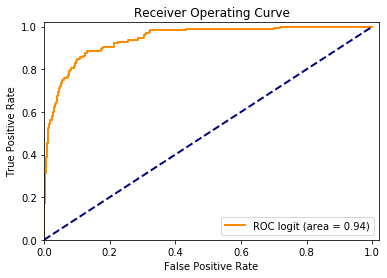

[[1439  196]
 [  23  146]]
Total Claims are $183,646,890
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $34,200,000
Total legal costs for investigating non-fradulent providers are 57% of total cost
Total Recovered claims are 98% of total defrauded claims
Net benefit of model as Pct of total claims is 176% of total claims


In [308]:
#model = search.best_estimator_
y_pred = logReg.predict(X_test)
logitMetrics(X_test,y_test,logReg);
print(confusion_matrix(y_test, y_pred))
ROC(X_test,y_test,logReg)
cost_model(y_test, y_pred)

In [62]:
def feature_importance(model, columns, name, note):
    coefs = pd.DataFrame(np.dstack((
        columns,model.named_steps[name].feature_importances_.round(4)))[0], 
                         columns = ['Features','Coefficients']).\
    sort_values('Coefficients',ascending=True).set_index('Features')
    
    coefs.to_csv('../data/feature_importances_'+name)

    coefs.plot(kind='barh', figsize=(9,7))
    plt.title(name + ' ' + note)
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    
    #print(coefs)

In [53]:
def cost_model(y, y_pred):
    reimbursement = data.loc[y.index,'InscClaimAmtReimbursed']
    df = pd.DataFrame(
        {
            'actual':y,
            'prediction':y_pred,
            'reimbursement': reimbursement # total amounts per provider
        }
    )
    cost_of_investigation = 100000
    cm = confusion_matrix(y, y_pred)
    print(cm)

    totalclaims =      np.sum(df['reimbursement'])
    totaldefrauded =   np.sum(df.query('actual==1')['reimbursement'])

    totalcost =        np.sum(df.query('prediction==1')['prediction'])*cost_of_investigation
    totalfalsepos =    np.sum(df.query('prediction==1 & actual==0')['prediction'])*cost_of_investigation
    totalrecovered =   np.sum(df.query('prediction==1 & actual==1')['reimbursement'])

    pct_fraud = totaldefrauded/totalclaims
    falsepos_pct = totalfalsepos/totalcost
    recov_pct = totalrecovered/totaldefrauded
    net_benefit_pct = totalrecovered/(totalcost + totalfalsepos)

    print('Total Claims are ${:,.0f}'.format(totalclaims))
    print('Percentage of total reimbursements associated with fraudulent providers is {:.0%}'.format(pct_fraud))
    print('Cost to insurer at 100K per provider investigation ${:,.0f}'.format(totalcost))
    print('Total legal costs for investigating non-fradulent providers are {:.0%} of total cost'.format(falsepos_pct))
    print('Total Recovered claims are {:.0%} of total defrauded claims'.format(recov_pct))
    print('Net benefit of model as Pct of total claims is {:.0%} of total claims'.format(net_benefit_pct))

In [418]:
total_defrauded = 1e8
total_recovered = 5e7

totalcost = 1e5 * 150
totalfalsepos = 1e5 * 50

total_recovered / (totalcost + totalfalsepos)

2.5

## AdaBoostClassifier

In [529]:
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

name = 'AdaBoost'

X_train, X_test, y_train, y_test = tts(X, y,random_state=4, test_size=1.0/3)

#anova_filter = SelectKBest(f_regression, k =4)

mutual_info_filter = SelectKBest(mutual_info_classif, k = 5)

param_grid = dict(
    #ada__n_estimators = range(100,401,100),
    #ada__learning_rate = np.linspace(0.2,1.5,10),
    #ada__random_state = range(0,5)
)

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         #('mInfo', mutual_info_filter),
         (name, AdaBoostClassifier(
             n_estimators = 400,
             random_state = 0,
             learning_rate = 0.2
         ))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      param_grid=param_grid,
                      cv = cv,
                      scoring = 'f1').fit(X_train,y_train)

_ = model.fit(X_train,y_train)


# model = search.best_estimator_
#print(model_.best_params_)

In [530]:
model_ada = search.best_estimator_

In [531]:
model_ada.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('AdaBoost',
                 AdaBoostClassifier(learning_rate=0.2, n_estimators=400,
                                    random_state=0))])>

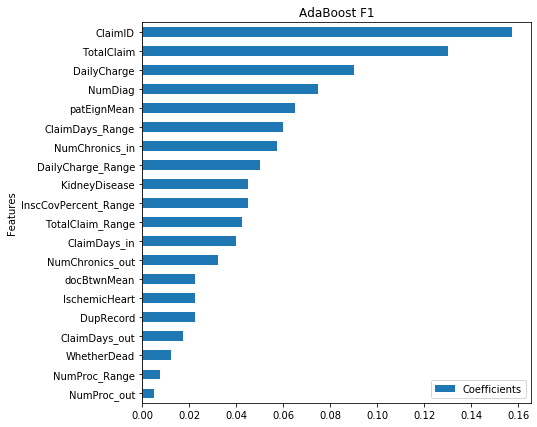

In [532]:
feature_importance(model_ada, X.columns, 'AdaBoost', 'F1')

 Logit Train Accuracy : 0.941
 Logit Train Precision: 0.965 (no fraud) and 0.690 (fraud)
 Logit Train Recall   : 0.970 (no fraud) and 0.657 (fraud)
 Logit Train F1 Score : 0.968 (no fraud) and 0.673 (fraud)
[[0.8808204  0.02716186]
 [0.03159645 0.06042129]]


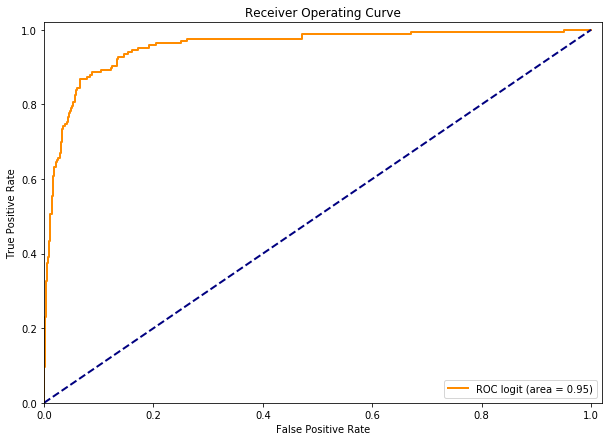

[[1589   49]
 [  57  109]]
Total Claims are $191,583,380
Percentage of total reimbursements associated with fraudulent providers is 52%
Cost to insurer at 100K per provider investigation $15,800,000
Total legal costs for investigating non-fradulent providers are 31% of total cost
Total Recovered claims are 89% of total defrauded claims
Net benefit of model as Pct of total claims is 428% of total claims


In [533]:

y_pred = model_ada.predict(X_test)
logitMetrics(X_test,y_test,model_ada);
cm =confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
ROC(X_test,y_test,model_ada)
cost_model(y_test, y_pred)

## MLP Classifier

In [328]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = tts(X, y,random_state=42, test_size=1.0/3)

#anova_filter = SelectKBest(f_regression, k =10)

param_grid = dict(#MLP__learning_rate_init = np.linspace(0.05,0.13,5),
                  #MLP__alpha=np.logspace(-4,-1,5)
                  #MLP__max_iter = range(500,1000,100)
                 )

name = 'MLP'
steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         (name, MLPClassifier(random_state=1,
                              alpha=0.1,
                              max_iter=500,
                              learning_rate_init=0.1,
                              activation = 'relu',
                              warm_start=True,
                              learning_rate='adaptive'))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      cv = cv,
                      param_grid=param_grid,
                      scoring = 'f1').fit(X_train,y_train)



model_MLP = search.best_estimator_

In [329]:
model_MLP.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('MLP',
                 MLPClassifier(alpha=0.1, learning_rate='adaptive',
                               learning_rate_init=0.1, max_iter=500,
                               random_state=1, warm_start=True))])>

 Logit Train Accuracy : 0.933
 Logit Train Precision: 0.940 (no fraud) and 0.793 (fraud)
 Logit Train Recall   : 0.988 (no fraud) and 0.417 (fraud)
 Logit Train F1 Score : 0.964 (no fraud) and 0.547 (fraud)
[[1610   19]
 [ 102   73]]


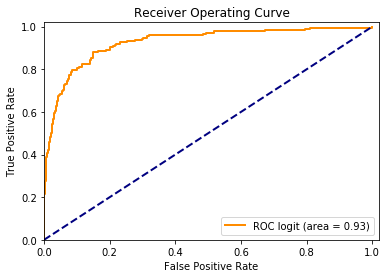

[[1610   19]
 [ 102   73]]
Total Claims are $172,809,940
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $9,200,000
Total legal costs for investigating non-fradulent providers are 21% of total cost
Total Recovered claims are 72% of total defrauded claims
Net benefit of model as Pct of total claims is 590% of total claims


In [330]:

y_pred = model_MLP.predict(X_test)
logitMetrics(X_test,y_test,model_MLP);
cm =confusion_matrix(y_test, y_pred)
print(cm)
ROC(X_test,y_test,model_MLP)
cost_model(y_test, y_pred)

## LogitBoost

In [485]:
from logitboost import LogitBoost
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size=1.0/3)
anova_filter = SelectKBest(f_regression, k =10)

param_grid = dict()
    #lboost__n_estimators = range(100,351,50),
    #lboost__learning_rate = np.logspace(-3,0,10))       

name = 'lboost'
steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         (name, LogitBoost(
             n_estimators = 400,
             learning_rate=0.46415888336127775,
             random_state=0))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      param_grid=param_grid,
                      cv = cv,
                      scoring = 'f1').fit(X_train,y_train)

#_ = model.fit(X_train,y_train)

In [486]:
model_logit = search.best_estimator_
model_logit.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('lboost',
                 LogitBoost(learning_rate=0.46415888336127775, n_estimators=400,
                            random_state=0))])>

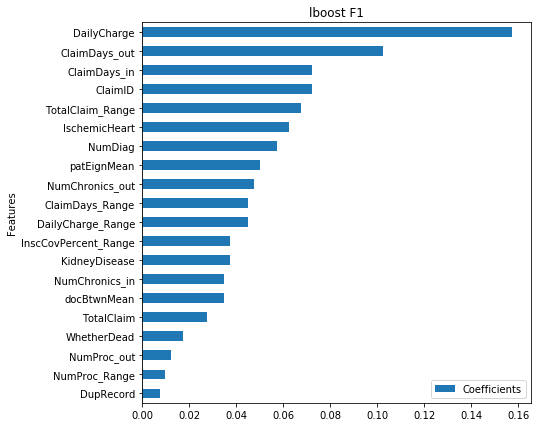

In [487]:
feature_importance(model_logit, X.columns, name, 'F1')

 Logit Train Accuracy : 0.950
 Logit Train Precision: 0.965 (no fraud) and 0.775 (fraud)
 Logit Train Recall   : 0.980 (no fraud) and 0.651 (fraud)
 Logit Train F1 Score : 0.972 (no fraud) and 0.707 (fraud)
[[0.88858093 0.01773836]
 [0.0327051  0.06097561]]


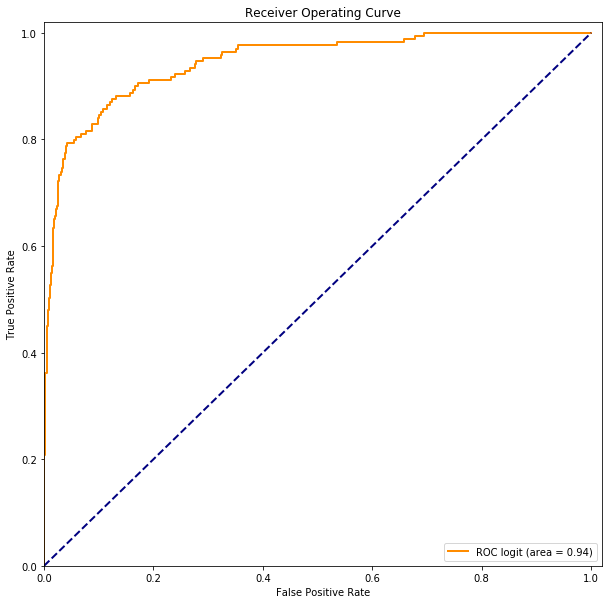

[[1603   32]
 [  59  110]]
Total Claims are $183,646,890
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $14,200,000
Total legal costs for investigating non-fradulent providers are 23% of total cost
Total Recovered claims are 90% of total defrauded claims
Net benefit of model as Pct of total claims is 498% of total claims


In [488]:
y_pred = model_logit.predict(X_test)
logitMetrics(X_test,y_test,model_logit);
cm =confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
ROC(X_test,y_test,model_logit)
cost_model(y_test, y_pred)

## Combining Models

In [489]:
pred_MLP_AND_logit = np.logical_and(model_MLP.predict(X_test),model_logit.predict(X_test))

y_pred = pred_MLP_AND_logit
cost_model(y_test, y_pred)

[[1619   16]
 [  91   78]]
Total Claims are $183,646,890
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $9,400,000
Total legal costs for investigating non-fradulent providers are 17% of total cost
Total Recovered claims are 79% of total defrauded claims
Net benefit of model as Pct of total claims is 695% of total claims


In [490]:
pred_MLP_OR_logit = np.logical_or(model_MLP.predict(X_test),model_logit.predict(X_test))

y_pred = pred_MLP_OR_logit
cost_model(y_test, y_pred)

[[1597   38]
 [  53  116]]
Total Claims are $183,646,890
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $15,400,000
Total legal costs for investigating non-fradulent providers are 25% of total cost
Total Recovered claims are 93% of total defrauded claims
Net benefit of model as Pct of total claims is 466% of total claims


In [338]:
import lime
import lime.lime_tabular

In [ ]:
predict_fn_MLP = lambda x: model_MLP.predict_proba(x).astype(float)
feature_names = list(X.columns)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names = feature_names,
    class_names = ['No','Yes'],
    kernel_width=2)

In [341]:
obs1 = 45

exp = explainer.explain_instance(X_test.values[obs1], predict_fn_MLP, num_features=7)
exp.show_in_notebook(show_all=False)

In [342]:
obs1 = 2

exp = explainer.explain_instance(X_test.values[obs1], predict_fn_MLP, num_features=7)
exp.show_in_notebook(show_all=False)

## Model Evaluations

Automatically created module for IPython interactive environment


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

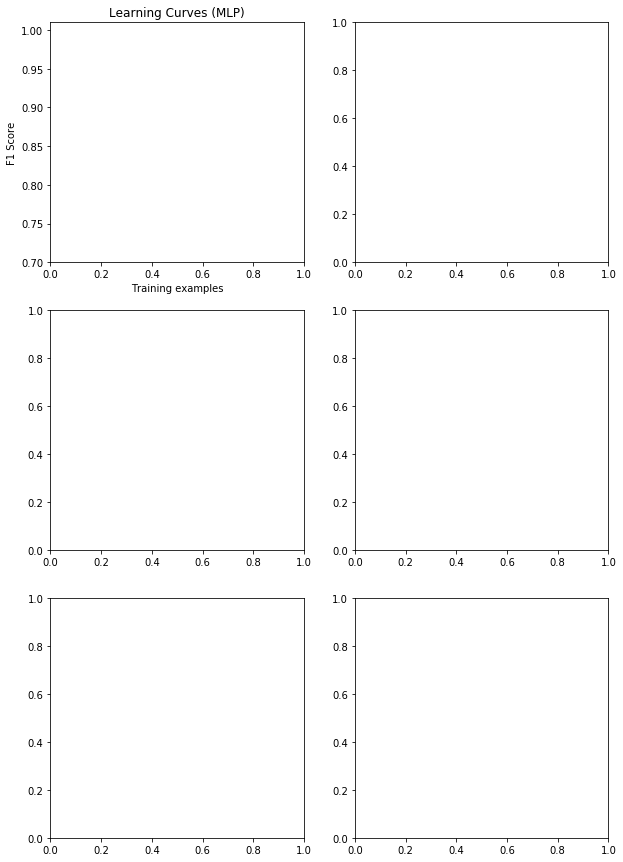

In [209]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("F1 Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       scoring = 'f1_weighted',
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("F1 Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves (MLP)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedStratifiedKFold(n_splits = 20, n_repeats = 1, random_state = 1)

name = 'MLP'
steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         (name, MLPClassifier(random_state=1,
                              alpha=0.1,
                              max_iter=500,
                              learning_rate_init=0.1,
                              learning_rate='adaptive'))]

estimator = Pipeline(steps = steps)

plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (LogitBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = RepeatedStratifiedKFold(n_splits = 20, n_repeats = 1, random_state = 1)

name = 'lboost'
steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         (name, LogitBoost(
             n_estimators = 200,
             learning_rate=0.46415888336127775,
             random_state=0))]

estimator = Pipeline(steps = steps)

plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

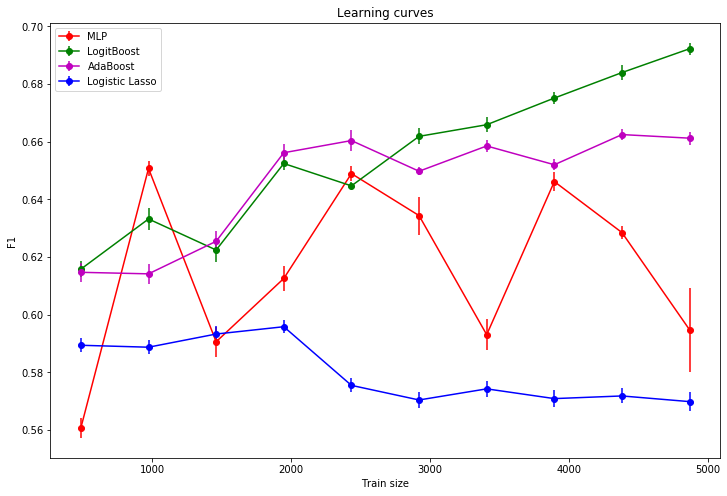

In [299]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Visualize learning curves
plt.figure(figsize=(12,8))

cv = StratifiedKFold(n_splits = 10,shuffle=False, random_state = 1)

#####################################################################
name = 'MLP'
steps = [('scaler', StandardScaler()),
         (name, MLPClassifier(random_state=1,
                              alpha=0.1,
                              max_iter=500,
                              learning_rate_init=0.1,
                              learning_rate='adaptive'))]
MLP = Pipeline(steps = steps)

train_sizes, train_scores_mlp, test_scores_mlp = \
    learning_curve(MLP, X, y, 
                   train_sizes=np.linspace(0.1, 1, 10),
                   scoring="f1", cv=cv)

#####################################################################
name = 'lboost'
steps = [('scaler', StandardScaler()),
         (name, LogitBoost(
             n_estimators = 200,
             learning_rate=0.46415888336127775,
             random_state=0))]
logitBoost = Pipeline(steps = steps)

train_sizes_abs, train_scores_lb, test_scores_lb = \
    learning_curve(logitBoost, X, y, 
                   train_sizes=np.linspace(0.1, 1, 10),
                   scoring="f1", cv=cv)

#####################################################################
steps = [('scaler', StandardScaler()),
         (name, AdaBoostClassifier(
             n_estimators = 100,
             random_state = 0,
             learning_rate = 0.2
         ))]
ada = Pipeline(steps = steps)


train_sizes_abs, train_scores_ada, test_scores_ada = \
    learning_curve(ada, X, y, 
                   train_sizes=np.linspace(0.1, 1, 10),
                   scoring="f1", cv=cv)



#####################################################################
steps = [('scaler', StandardScaler()),
         (name, LogisticRegression(
                 C=1.374,
                 penalty = 'l1',
                 class_weight='balanced',
                 solver = 'liblinear',
             ))]
logit = Pipeline(steps = steps)

train_sizes_abs, train_scores_logit, test_scores_logit = \
    learning_curve(logit, X, y, 
                   train_sizes=np.linspace(0.1, 1, 10),
                   scoring="f1", cv=cv)

#####################################################################


plt.errorbar(train_sizes, test_scores_mlp.mean(1), yerr=test_scores_mlp.var(1), 
             fmt='o-', color="r",
         label="MLP")

plt.errorbar(train_sizes, test_scores_lb.mean(1),  yerr=test_scores_lb.var(1), 
             fmt='o-', color="g",
         label="LogitBoost")

plt.errorbar(train_sizes, test_scores_ada.mean(1), yerr=test_scores_ada.var(1), 
             fmt='o-', color="m",
         label="AdaBoost")


plt.errorbar(train_sizes, test_scores_logit.mean(1), yerr=test_scores_logit.var(1), 
             fmt='o-', color="b",
         label="Logistic Lasso")

plt.xlabel("Train size")
plt.ylabel("F1")
plt.title('Learning curves')
plt.legend(loc="best")
#plt.savefig("../visualizations/learning_curve_unshuffled.png",bbox_inches='tight')
plt.show()


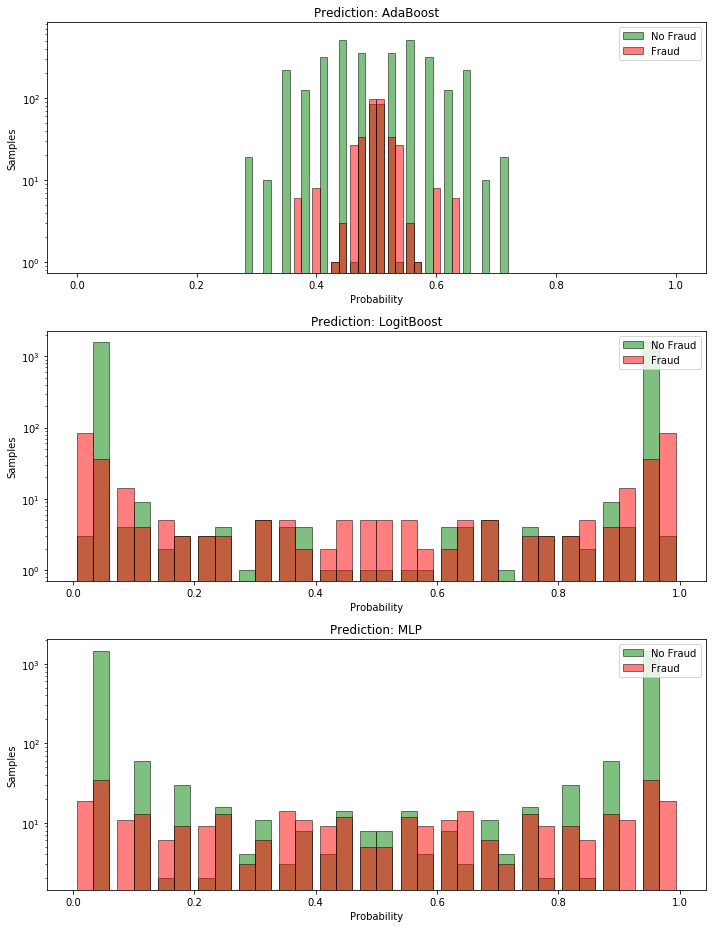

In [396]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_gaussian_quantiles


# # Create and fit an AdaBoosted decision tree
# bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
#                          algorithm="SAMME",
#                          n_estimators=200)

# bdt.fit(X, y)

# 
# plot_step = 0.02
# class_names = "AB"


# # Plot the decision boundaries
# plt.subplot(121)
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                      np.arange(y_min, y_max, plot_step))

# Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)
# cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.axis("tight")

# # Plot the training points
# for i, n, c in zip(range(2), class_names, plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(X[idx, 0], X[idx, 1],
#                 c=c, cmap=plt.cm.Paired,
#                 s=20, edgecolor='k',
#                 label="Class %s" % n)
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.legend(loc='upper right')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Decision Boundary')

# Plot the two-class decision scores


fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,13))

class_names = ['No Fraud','Fraud']
plot_colors = "gr"
logit_output = model_logit.predict_proba(X_test)
plot_range = (logit_output.min(), logit_output.max())
plt.subplot(312)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(logit_output[y_test == i],
             bins=15,
             range=plot_range,
             facecolor=c,
             histtype='bar',
             label='%s' % n,
             alpha=.5,
             edgecolor='k')
plt.yscale('log', nonposy='clip')
# x1, x2, y1, y2 = plt.axis()
# plt.axis((0.0, 1.0, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
#plt.yscale('log')
plt.xlabel('Probability')
plt.title('Prediction: LogitBoost')

plt.tight_layout()

ada_output = model_ada.predict_proba(X_test)
plot_range = (ada_output.min(), ada_output.max())
plt.subplot(311)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(ada_output[y_test == i],
             bins=15,
             range=plot_range,
             facecolor=c,
             histtype='bar',
             label='%s' % n,
             alpha=.5,
             edgecolor='k')
plt.yscale('log', nonposy='clip')
x1, x2, y1, y2 = plt.axis()
plt.axis((-0.05, 1.05, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
#plt.yscale('log')
plt.xlabel('Probability')
plt.title('Prediction: AdaBoost')

plt.tight_layout()

MLP_output = model_MLP.predict_proba(X_test)
plot_range = (MLP_output.min(), MLP_output.max())
plt.subplot(313)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(MLP_output[y_test == i],
             bins=15,
             range=plot_range,
             facecolor=c,
             histtype='bar',
             label='%s' % n,
             alpha=.5,
             edgecolor='k')
    
plt.yscale('log', nonposy='clip')
# x1, x2, y1, y2 = plt.axis()

# plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Probability')
plt.title('Prediction: MLP')

plt.tight_layout()

plt.subplots_adjust(wspace=0.35)
plt.show()

Average precision-recall score: 0.83


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.83')

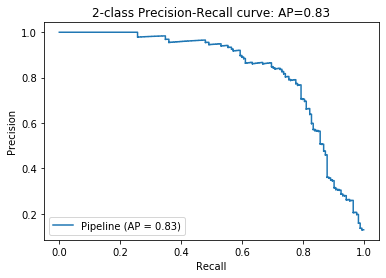

In [400]:
from sklearn.metrics import average_precision_score


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


y_score = model_logit.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(model_logit, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Average precision-recall score: 0.77


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.77')

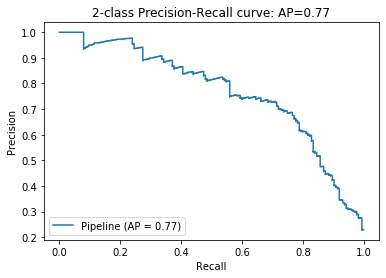

In [401]:

y_score = model_ada.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(model_ada, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

<Figure size 504x576 with 0 Axes>

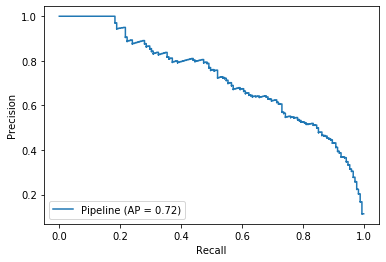

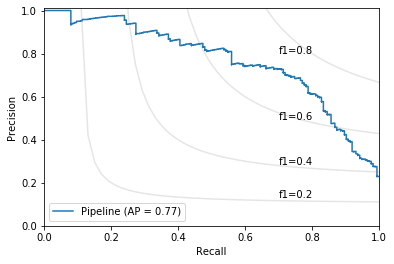

In [429]:



plt.figure(figsize=(7, 8))
lines = []

## LogReg
y_score = logReg.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
logReg_prec = plot_precision_recall_curve(logReg, X_test, y_test)

lines.append(logReg_prec)

## AdaBoost
y_score = model_ada.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
ada_prec = plot_precision_recall_curve(model_ada, X_test, y_test)

lines.append(ada_prec)

f_scores = np.linspace(0.2, 0.8, num=4)

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[40] + 0.02))
    
    
plt.axis((0, 1, 0, 1 * 1.01))
#labels.append('iso-f1 curves')
#l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)

# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

    
#fig = plt.gcf()
# fig.subplots_adjust(bottom=0.25)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Extension of Precision-Recall curve to multi-class')
#plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [434]:
X_train

,ClaimID,NumDiag,TotalClaim,DailyCharge,DupRecord,WhetherDead,KidneyDisease,IschemicHeart,ClaimDays_in,ClaimDays_out,NumChronics_in,NumChronics_out,NumProc_out,NumProc_Range,ClaimDays_Range,TotalClaim_Range,InscCovPercent_Range,DailyCharge_Range,docBtwnMean,patEignMean
Provider,,,,,,,,,,,,,,,,,,,,
PRV51708,4,2.250000,115.000000,115.000000,0,0,0.250000,0.250000,0.000000,1.000000,0.000000,4.750000,0.0,0,0,240.0,0.200000,240.000000,694.474029,0.003941
PRV56721,202,2.945545,301.683168,237.942390,0,0,0.430693,0.722772,0.000000,2.044554,0.000000,4.391089,0.0,0,20,3300.0,0.800000,3300.000000,0.000000,0.260708
PRV56182,51,2.784314,269.803922,127.942733,0,0,0.333333,0.803922,0.000000,3.313725,0.000000,4.745098,0.0,0,20,3300.0,0.538462,1200.000000,1.000000,0.907635
PRV56748,463,4.354212,3325.032397,775.189359,1,0,0.490281,0.788337,6.435897,2.355491,5.811966,4.554913,0.0,3,26,80068.0,1.000000,10689.333333,0.000000,0.167501
PRV53772,22,2.954545,245.909091,231.515152,0,0,0.409091,0.772727,0.000000,1.136364,0.000000,4.181818,0.0,0,2,1290.0,0.000000,1290.000000,0.000000,0.009395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV55724,31,3.516129,421.290323,286.405530,0,0,0.483871,0.645161,0.000000,2.548387,0.000000,4.193548,0.0,0,20,2200.0,0.833333,1800.000000,0.000000,0.150276
PRV57495,113,4.902655,3895.362832,758.513623,0,0,0.433628,0.734513,7.000000,1.500000,4.540541,4.473684,0.0,2,35,58068.0,1.000000,5517.000000,0.000000,0.075462
PRV57542,37,3.189189,144.864865,102.097090,0,0,0.540541,0.810811,0.000000,2.729730,0.000000,4.729730,0.0,0,20,1100.0,1.000000,500.000000,168.044119,0.039960


In [443]:
model_ada['AdaBoost']

AdaBoostClassifier(learning_rate=0.2, n_estimators=100, random_state=0)

In [534]:
from sklearn.metrics import f1_score


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

#train_f1 = []
ada_f1  = []
logit_f1  = []

#gen_train = model_ada['AdaBoost'].staged_predict(model_ada['scaler'].transform(X_train))  # generator
ada_test  = model_ada['AdaBoost'].staged_predict(model_ada['scaler'].transform(X_test))    # generator
logit_test  = model_logit['lboost'].staged_predict(model_logit['scaler'].transform(X_test))    # generator
steps     = range(1,401)

for n_estimators in steps:
            staged_Y_predict_ada = next(ada_test)
            staged_Y_predict_logit  = next(logit_test)
            ada_f1.append(f1_score(y_test, staged_Y_predict_ada))  
            logit_f1.append(f1_score(y_test, staged_Y_predict_logit))

The last n_estimators overfit at 400


Text(0, 0.5, 'F1')

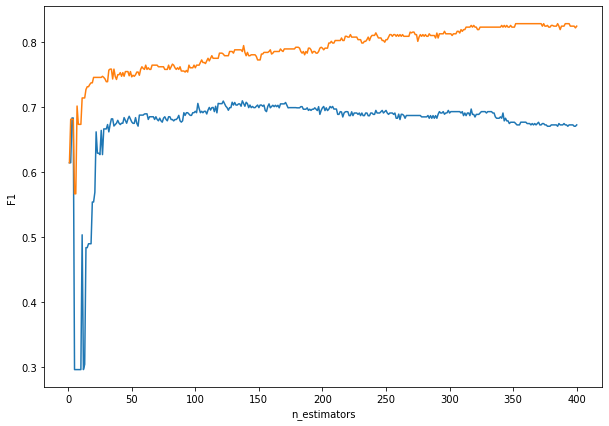

In [535]:
plt.rcParams['figure.figsize'] = (10,7)
plt.plot(steps, ada_f1, label='ada_accuracy')
plt.plot(steps, logit_f1, label='logit_accuracy')
underfitting  = np.array(ada_f1) - np.array(logit_f1) < 0
try:
    last_underfit = np.max(np.array(steps)[underfitting])
    print('The last n_estimators overfit at %d' %(last_underfit))
except:
    last_underfit = 500
plt.xlabel('n_estimators')
plt.ylabel('F1')

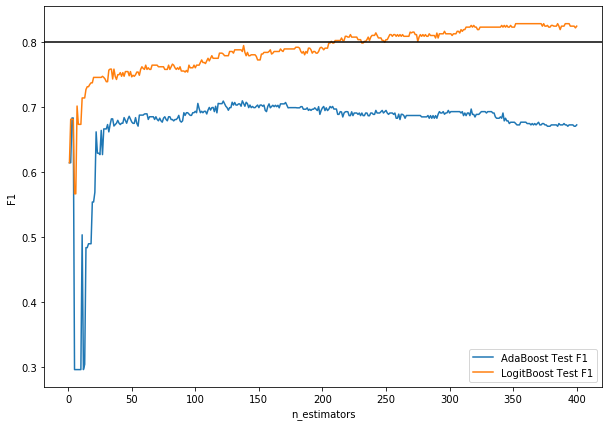

In [543]:
# To investigate what happens near this, we go beyond it for another 300 steps
loc = last_underfit+300
#plt.plot(steps[10:loc], train_f1[10:loc], label='train_f1')
plt.plot(steps, ada_f1, label='AdaBoost Test F1')
plt.plot(steps, logit_f1, label='LogitBoost Test F1')

plt.legend(loc=4)
plt.xlabel('n_estimators')
plt.ylabel('F1')
plt.axhline(0.8, color ='k')

In [480]:
steps = [1, 50, 100, model_ada['AdaBoost'].n_estimators]
gen_proba = model_ada['AdaBoost'].staged_predict_proba(model_ada['scaler'].transform(X))

totalFrame = None

for n_estimators in range(1, steps[-1]+1):
            probs = next(gen_proba)[:,1]
            if n_estimators not in steps: continue
            prob_bin = pd.cut(probs, 50, labels=False)
            df    = pd.DataFrame({'prob_bin':prob_bin, 'probs':probs, 'target':y})
            ans   = df.groupby('prob_bin').mean()
            ans['n_estimators'] = np.ones(ans.shape[0], dtype=np.int32) * n_estimators
            totalFrame = ans.copy() if totalFrame is None else pd.concat([totalFrame, ans], axis=0)                  

In [481]:
totalFrame

,probs,target,n_estimators
prob_bin,,,
0,0.034945,0.031145,1
49,0.568579,0.544073,1
0,0.217481,0.000000,50
1,0.233702,0.000000,50
2,0.240836,0.000000,50
...,...,...,...
39,0.563328,1.000000,200
40,0.568159,1.000000,200
41,0.570280,1.000000,200


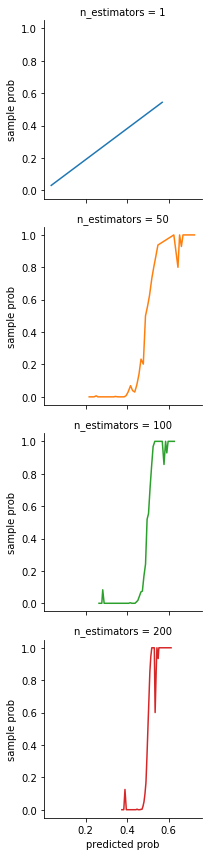

In [482]:
plt.rcParams['figure.figsize'] = (10,7)
import seaborn as sns 
totalFrame.columns = ['predicted prob', 'sample prob', 'n_estimators']
g = sns.FacetGrid(data=totalFrame, row = 'n_estimators', hue = 'n_estimators')
g.map(sns.lineplot, 'predicted prob', 'sample prob')

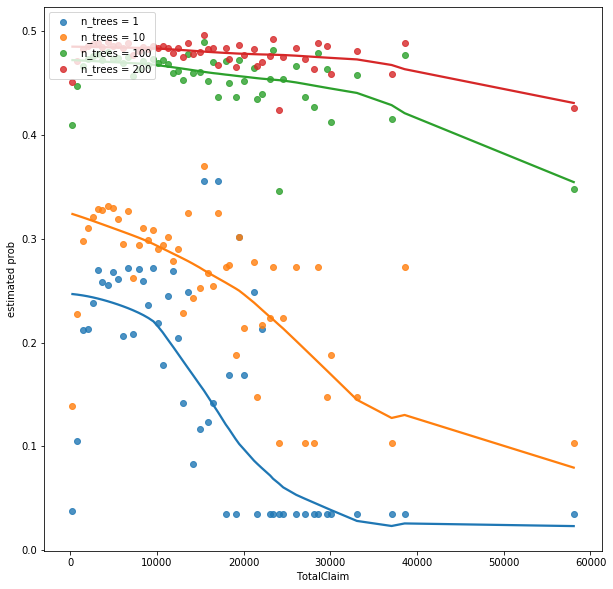

In [492]:
plt.rcParams['figure.figsize'] = (10,10)

gen_proba = model_ada['AdaBoost'].staged_predict_proba(model_ada['scaler'].transform(X))

token = 'TotalClaim'
steps = [1,10, 100, model_ada['AdaBoost'].n_estimators]

for n_estimators in range(1, model_ada['AdaBoost'].n_estimators+1):
        prob = next(gen_proba)
        if n_estimators not in steps: continue
            
        indep = data[token]   
        U = pd.DataFrame({token:indep, 'bins':pd.cut(indep,100,labels=False), 'estimated prob':prob[:,1]})
        W = U.groupby('bins').mean()
        sns.regplot(data = W, x = token, y='estimated prob', label='n_trees = %d' %(n_estimators), lowess=True)
plt.legend(loc=2)  

Text(0, 0.5, 'Estimated Probability')

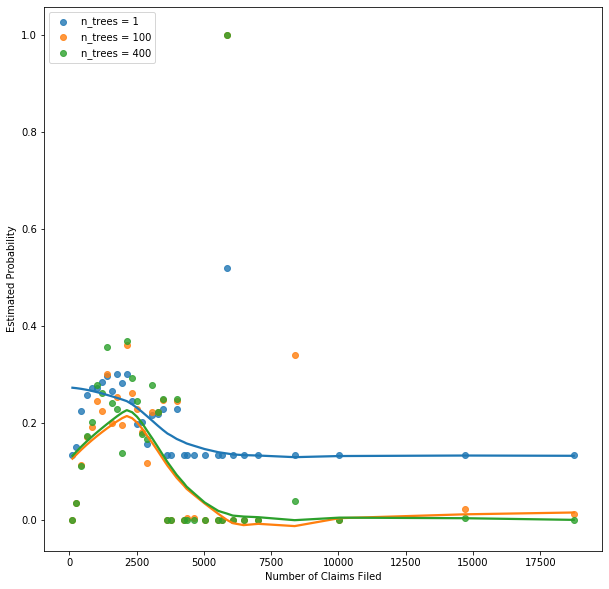

In [513]:
plt.rcParams['figure.figsize'] = (10,10)

gen_proba = model_logit['lboost'].staged_predict_proba(model_logit['scaler'].transform(X))

token = 'DailyCharge'
steps = [1, 100, model_logit['lboost'].n_estimators]

for n_estimators in range(1, model_logit['lboost'].n_estimators+1):
        prob = next(gen_proba)
        if n_estimators not in steps: continue
            
        indep = data[token]   
        U = pd.DataFrame({token:indep, 'bins':pd.cut(indep,100,labels=False), 'estimated prob':prob[:,1]})
        W = U.groupby('bins').mean()
        sns.regplot(data = W, x = token, y='estimated prob', label='n_trees = %d' %(n_estimators), lowess=True)
plt.legend(loc=2) 
plt.xlabel('Number of Claims Filed')
plt.ylabel('Estimated Probability')

In [506]:
X.columns

Index(['ClaimID', 'NumDiag', 'TotalClaim', 'DailyCharge', 'DupRecord',
       'WhetherDead', 'KidneyDisease', 'IschemicHeart', 'ClaimDays_in',
       'ClaimDays_out', 'NumChronics_in', 'NumChronics_out', 'NumProc_out',
       'NumProc_Range', 'ClaimDays_Range', 'TotalClaim_Range',
       'InscCovPercent_Range', 'DailyCharge_Range', 'docBtwnMean',
       'patEignMean'],
      dtype='object')

In [515]:
import sklearn
version = sklearn.__version__
if version[:4]<'0.21':
     from sklearn.ensemble.partial_dependence import plot_partial_dependence
     # will be removed after sklearn '0.23'
else:
     from sklearn.inspection import plot_partial_dependence

In [517]:
sorted(zip(X.columns, model_logit['lboost'].feature_importances_), key=lambda t:t[1], reverse=True)

[('DailyCharge', 0.1575),
 ('ClaimDays_out', 0.1025),
 ('ClaimID', 0.0725),
 ('ClaimDays_in', 0.0725),
 ('TotalClaim_Range', 0.0675),
 ('IschemicHeart', 0.0625),
 ('NumDiag', 0.0575),
 ('patEignMean', 0.05),
 ('NumChronics_out', 0.0475),
 ('ClaimDays_Range', 0.045),
 ('DailyCharge_Range', 0.045),
 ('KidneyDisease', 0.0375),
 ('InscCovPercent_Range', 0.0375),
 ('NumChronics_in', 0.035),
 ('docBtwnMean', 0.035),
 ('TotalClaim', 0.0275),
 ('WhetherDead', 0.0175),
 ('NumProc_out', 0.0125),
 ('NumProc_Range', 0.01),
 ('DupRecord', 0.0075)]

In [519]:
features = ['DailyCharge', ('ClaimID', 'DailyCharge')]
plot_partial_dependence(model_logit, X, features, feature_names=X.columns.tolist())

KeyboardInterrupt: 